# 04wk-2: 깊은신경망 (3) – 오버피팅, 드랍아웃, 신경망의 표현

최규빈  
2024-03-27

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/04wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-wD7Am2wZ7NNZjHpt55gwEH&si=Yj3LYi8Y9uU5SYtp >}}

# 2. Imports

In [3]:
import torch
import matplotlib.pyplot as plt

# 3. 오버피팅 (시벤코정리의 이면)

## A. 오버피팅

`-` 오버피팅이란?

-   위키: In mathematical modeling, overfitting is “the production of an
    analysis that corresponds too closely or exactly to a particular set
    of data, and may therefore fail to fit to additional data or predict
    future observations reliably”.
-   제 개념: 데이터를 “데이터 = 언더라잉 + 오차”라고 생각할때 우리가
    데이터로부터 적합할 것은 언더라잉인데 오차항을 적합하고 있는 현상.

## B. 오버피팅 예시

`-` $m$이 매우 클때 아래의 네트워크 거의 무엇이든 맞출 수 있다고 보면
된다.

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 그런데 종종 맞추지 말아야 할 것들도 맞춘다.

model: $y_i = (0\times x_i) + \epsilon_i$, where
$\epsilon_i \sim N(0,0.01^2)$

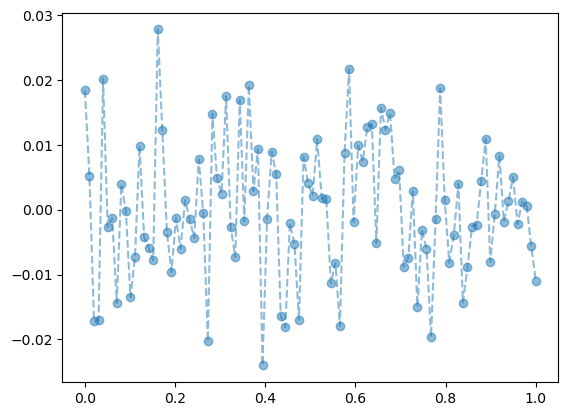

In [50]:
torch.manual_seed(5) 
x = torch.linspace(0,1,100).reshape(100,1)
y = torch.randn(100).reshape(100,1)*0.01
plt.plot(x,y,'--o',alpha=0.5)

-   y는 그냥 정규분포에서 생성한 오차이므로 $X \to y$ 로 향하는
    규칙따위는 없음

In [52]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizr= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

for epoc in range(1000): 
    ## 1 
    yhat=net(x) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    net.zero_grad() 

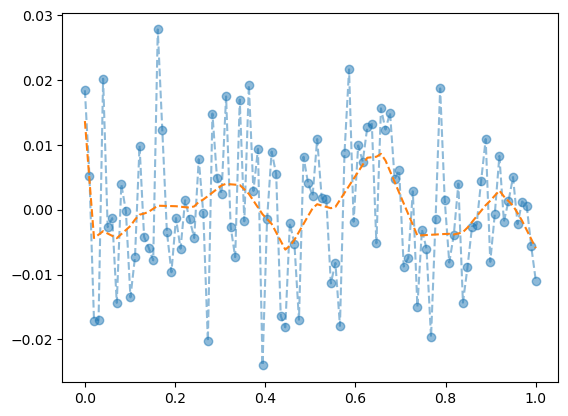

In [57]:
plt.plot(x,y,'--o',alpha=0.5)
plt.plot(x,net(x).data,'--')

-   우리는 데이터를 랜덤에서 뽑았는데, 데이터의 추세를 따라간다 $\to$
    오버피팅 (underlying이 아니라 오차항을 따라가고 있음)

## C. 오버피팅이라는 뚜렷한 증거! (train / test)

`-` 데이터의 분리하여 보자.

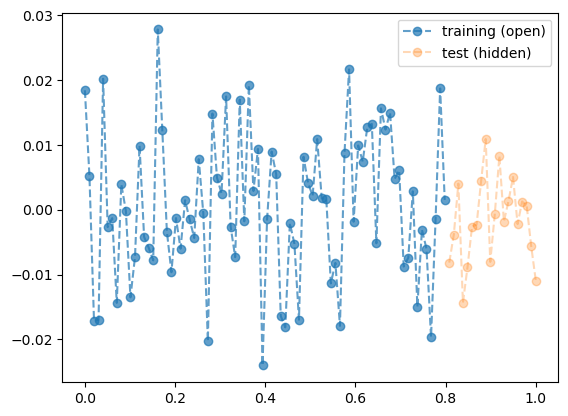

In [63]:
torch.manual_seed(5) 
x_all = torch.linspace(0,1,100).reshape(100,1)
y_all = torch.randn(100).reshape(100,1)*0.01
x = x_all[:80] 
y = y_all[:80]
xx = x_all[80:]
yy = y_all[80:]
plt.plot(x,y,'--o',label="training (open)",alpha=0.7)
plt.plot(xx,yy,'--o',label="test (hidden)",alpha=0.3)
plt.legend()

`-` train만 학습

In [68]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizr= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

for epoc in range(1000): 
    ## 1 
    yhat = net(x) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

`-` training data로 학습한 net를 training data 에 적용

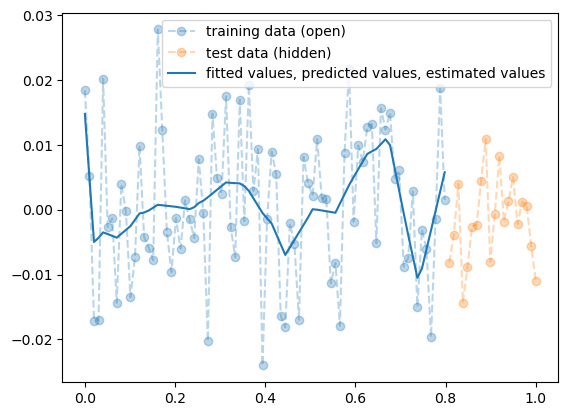

In [78]:
plt.plot(x,y,'--o',label="training data (open)",alpha=0.3)
plt.plot(xx,yy,'--o',label="test data (hidden)",alpha=0.3)
plt.plot(x,net(x).data,label="fitted values, predicted values, estimated values",color="C0")
plt.legend()

-   train에서는 잘 맞추는듯이 보인다.

`-` training data로 학습한 net를 test data 에 적용

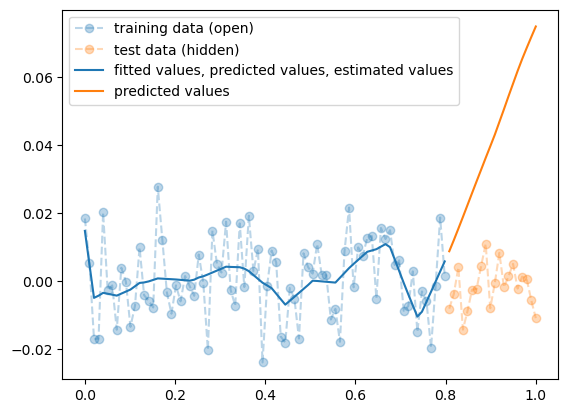

In [81]:
plt.plot(x,y,'--o',label="training data (open)",alpha=0.3)
plt.plot(xx,yy,'--o',label="test data (hidden)",alpha=0.3)
plt.plot(x,net(x).data,label="fitted values, predicted values, estimated values",color="C0")
plt.plot(xx,net(xx).data,label="predicted values",color="C1")
plt.legend()

-   train은 그럭저럭 따라가지만 test에서는 엉망이다. $\to$ overfit

## D. 시벤코정리의 올바른 이해

> **시벤코정리의 항변(?) (Cybenko 1989)**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크
> $net: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$는
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(), ## <-- 여기에 렐루를 써도 된다. 
>     torch.nn.Linear(???,q)
> )
> ```
>
> 모든 continuous mapping
>
> $$f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$$
>
> 를 원하는 정확도로 “근사”시킬 수 있다 (즉 마음만 먹으면 loss를 0에
> 가깝도록 만들 수 있다는 의다) 쉽게 말하면 ${\bf X} \to {\bf y}$ 인
> 어떠한 복잡한 규칙라도 하나의 은닉층을 가진 심층신경망(DNN)이 원하는
> 정확도로 근사시킨다는 의미이다. **그렇지만 이러한 규칙이 네크워크가
> 학습하지 못했던 자료 (처음 보는 자료, unseen data)
> ${\bf XX}_{m \times p}$, ${\bf yy}_{m \times p}$ 에 대하여서도
> 올바르게 적용된다라는 보장은 없다**. 즉
>
> $${\bf X}_{n \times p} \to {\bf y}_{n\times q}$$
>
> 를 원하는 정확도로 근사시킨 네트워크라고 할지라도
>
> $${\bf XX}_{n \times p} \to {\bf yy}_{n\times q}$$
>
> 는 엉터리로 나올 수 있다. 시벤코는 넓은 신경망이 가지는 표현력의
> 한계를 수학적으로 밝혔을 뿐이다. 넓은 신경망이 우수한 신경망[1]이라는
> 주장을 한적 없다.

# 4. 드랍아웃

## A. 오버피팅의 해결

`-` 오버피팅의 해결책: 드랍아웃

[1] 여기에서 우수하다는 말은 여러의미가 있어요, 통계학적으로 우수한
신경망이라든가, 경제적인 신경망이라든가..

In [13]:
torch.manual_seed(1) 
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.8),
    torch.nn.Linear(in_features=512,out_features=1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

for epoc in range(1000):
    ## 1 
    #
    ## 2 
    loss = loss_fn(net(xtr),ytr) 
    ## 3 
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

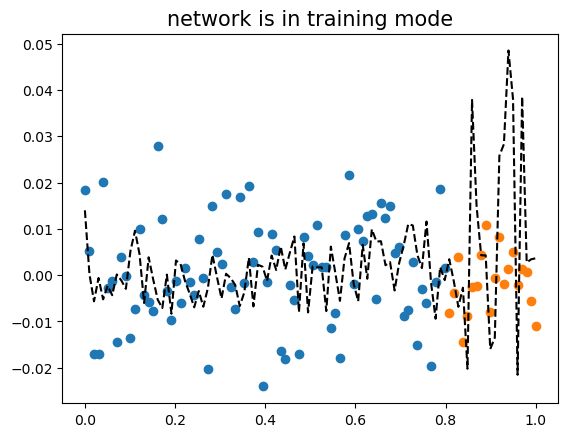

In [14]:
plt.plot(xtr,ytr,'o')
plt.plot(xtest,ytest,'o')
plt.plot(x,net(x).data,'--k') 
plt.title(r"network is in training mode",fontsize=15)

`-` 올바른 사용법

In [15]:
net.training

In [16]:
net.eval()
net.training

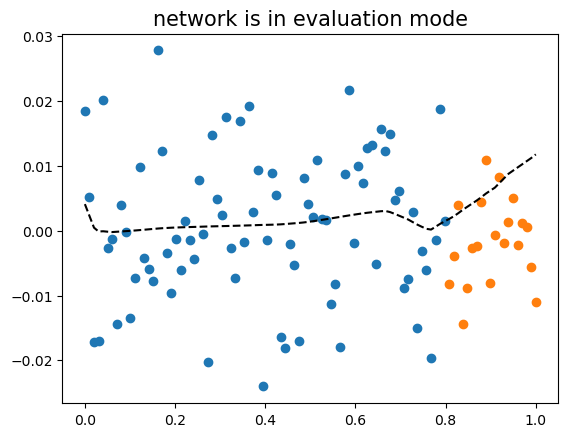

In [17]:
plt.plot(xtr,ytr,'o')
plt.plot(xtest,ytest,'o')
plt.plot(x,net(x).data,'--k') 
plt.title(r"network is in evaluation mode",fontsize=15)

## B. 드랍아웃 레이어

In [18]:
_x = torch.linspace(0,1,101) 
_x 

In [19]:
dout = torch.nn.Dropout(0.9)
dout(_x)

-   90%의 드랍아웃: 드랍아웃층의 입력 중 임의로 90%를 골라서 결과를
    0으로 만든다. + 그리고 0이 되지않고 살아남은 값들은 10배 만큼 값이
    커진다.

`-` 드랍아웃레이어 정리

-   구조: 입력 -\> 드랍아웃레이어 -\> 출력
-   역할: (1) 입력의 일부를 임의로 0으로 만드는 역할 (2) 0이 안된것들은
    스칼라배하여 드랍아웃을 통과한 모든 숫자들의 총합이 일정하게 되도록
    조정
-   효과: 오버피팅을 억제하는 효과가 있음 (왜??)
-   의미: each iteration (each epoch x) 마다 학습에 참여하는 노드가
    로테이션으로 랜덤으로 결정됨.
-   느낌: 모든 노드가 골고루 학습가능 + 한 두개의 특화된 능력치가
    개발되기 보다 평균적인 능력치가 전반적으로 개선됨

> 오버피팅을 잡는 방법은 드랍아웃만 있는게 아니다..

# 5. 신경망의 표현 (${\boldsymbol x} \to \hat{\boldsymbol y}$ 로 가는 과정을 그림으로 표현)

## 예제1: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(1)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 모든 observation과 가중치를 명시한 버전

**(표현1)**

In [3]:
gv(''' 
    "1" -> "ŵ₀ + xₙ*ŵ₁,    bias=False"[label="* ŵ₀"]
    "xₙ" -> "ŵ₀ + xₙ*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + xₙ*ŵ₁,    bias=False" -> "ŷₙ"[label="sigmoid"]

    "." -> "...................................."[label="* ŵ₀"]
    ".." -> "...................................."[label="* ŵ₁"]
    "...................................." -> "..."[label=" "]

    "1 " -> "ŵ₀ + x₂*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x₂" -> "ŵ₀ + x₂*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x₂*ŵ₁,    bias=False" -> "ŷ₂"[label="sigmoid"]
    
    "1  " -> "ŵ₀ + x₁*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x₁" -> "ŵ₀ + x₁*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x₁*ŵ₁,    bias=False" -> "ŷ₁"[label="sigmoid"]
''')

-   단점: 똑같은 그림의 반복이 너무 많음

`-` observation 반복을 생략한 버전들

**(표현2)** 모든 $i$에 대하여 아래의 그림을 반복한다고 하면 (표현1)과
같다.

In [4]:
gv(''' 
    "1" -> "ŵ₀ + xᵢ*ŵ₁,    bias=False"[label="* ŵ₀"]
    "xᵢ" -> "ŵ₀ + xᵢ*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + xᵢ*ŵ₁,    bias=False" -> "ŷᵢ"[label="sigmoid"]

''')


**(표현3)** 그런데 (표현2)에서 아래와 같이 $x_i$, $y_i$ 대신에 간단히
$x$, $y$로 쓰는 경우도 많음

In [5]:
gv(''' 
    "1" -> "ŵ₀ + x*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x" -> "ŵ₀ + x*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x*ŵ₁,    bias=False" -> "ŷ"[label="sigmoid"]

''')


`-` 1을 생략한 버전들

**(표현4)** bais=False 대신에 bias=True를 주면 1을 생략할 수 있음

In [6]:
gv('''
"x" -> "x*ŵ₁,    bias=True"[label="*ŵ₁"] ;
"x*ŵ₁,    bias=True" -> "ŷ"[label="sigmoid"] ''')


**(표현4의 수정)** $\hat{w}_1$대신에 $\hat{w}$를 쓰는 것이 더 자연스러움

In [7]:
gv('''
"x" -> "x*ŵ,    bias=True"[label="*ŵ"] ;
"x*ŵ,    bias=True" -> "ŷ"[label="sigmoid"] ''')


**(표현5)** 선형변환의 결과는 아래와 같이 $u$로 표현하기도 한다.

In [8]:
gv('''
"x" -> "u";
"u" -> "y"[label="sigmoid"] ''')


> 다이어그램은 그리는 사람의 취향에 따라 그리는 방법이 조금씩 다릅니다.
> 즉 교재마다 달라요.

## 예제2: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

**참고: 코드로 표현**

``` python
torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

`-` 이해를 위해서 03kw-2에서 다루었던 아래의 상황을 고려하자.

![](https://guebin.github.io/DL2024/posts/03wk-2_files/figure-html/cell-11-output-1.png)

**(강의노트의 표현)**

In [9]:
gv('''
"x" -> " -x"[label="*(-1)"];
"x" -> " x"[label="*1"]
" x" -> "rlu(x)"[label="relu"] 
" -x" -> "rlu(-x)"[label="relu"] 
"rlu(x)" -> "u"[label="*(-4.5)"] 
"rlu(-x)" -> "u"[label="*(-9.0)"] 
"u" -> "sig(u)=yhat"[label="sig"] 
'''
)

**(좀 더 일반화된 표현)** 10월4일 강의노트 상황을 일반화하면 아래와
같다.

In [10]:
gv('''
"x" -> "u1[:,0]"[label="*(-1)"];
"x" -> "u1[:,1]"[label="*1"]
"u1[:,0]" -> "v1[:,0]"[label="relu"] 
"u1[:,1]" -> "v1[:,1]"[label="relu"] 
"v1[:,0]" -> "u2"[label="*(-9.0)"] 
"v1[:,1]" -> "u2"[label="*(-4.5)"] 
"u2" -> "v2=yhat"[label="sig"] 
'''
)

`*` Layer의 개념: ${\bf X}$에서 $\hat{\boldsymbol y}$로 가는 과정은
“선형변환+비선형변환”이 반복되는 구조이다. “선형변환+비선형변환”을
하나의 세트로 보면 아래와 같이 표현할 수 있다.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \left( \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \right) \overset{l_2}{\to} \left(\underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}\right), \quad \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{net({\bf X})}=\underset{(n,1)}{\hat{\boldsymbol y}}$

이것을 다이어그램으로 표현한다면 아래와 같다.

**(선형+비선형을 하나의 Layer로 묶은 표현)**

In [11]:
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "u1[:,0]"
    "X" -> "u1[:,1]"
    "u1[:,0]" -> "v1[:,0]"[label="relu"]
    "u1[:,1]" -> "v1[:,1]"[label="relu"]
    label = "Layer 1"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "v1[:,0]" -> "u2"
    "v1[:,1]" -> "u2"
    "u2" -> "v2=yhat"[label="sigmoid"]
    label = "Layer 2"
}
''')

***Layer를 세는 방법***

-   정석: 학습가능한 파라메터가 몇층으로 있는지…
-   일부 교재 설명: 입력층은 계산하지 않음, activation layer는 계산하지
    않음.
-   위의 예제의 경우 `number of layer = 2` 이다.

> 사실 input layer, activation layer 등의 표현을 자주 사용해서 layer를
> 세는 방법이 처음에는 헷갈립니다..

***Hidden Layer의 수를 세는 방법***

-   `Layer의 수 = Hidden Layer의 수 + 출력층의 수 = Hidden Layer의 수 + 1`
-   위의 예제의 경우 `number of hidden layer = 1` 이다.

`*` node의 개념: $u\to v$로 가는 쌍을 간단히 노드라는 개념을 이용하여
나타낼 수 있음.

**(노드의 개념이 포함된 그림)**

In [12]:
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "node1"
    "X" -> "node2"
    label = "Layer 1:relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "yhat "
    "node2" -> "yhat "
    label = "Layer 2:sigmoid"
}
''')

여기에서 `node의 숫자 = feature의 숫자`와 같이 이해할 수 있다. 즉 아래와
같이 이해할 수 있다.

**(“number of nodes = number of features”로 이해한 그림)**

In [13]:
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "feature1"
    "X" -> "feature2"
    label = "Layer 1:relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "feature1" -> "yhat "
    "feature2" -> "yhat "
    label = "Layer 2:sigmoid"
}
''')

> 다이어그램의 표현방식은 교재마다 달라서 모든 예시를 달달 외울 필요는
> 없습니다. 다만 임의의 다이어그램을 보고 대응하는 네트워크를 pytorch로
> 구현하는 능력은 매우 중요합니다.

## 예제3: $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

**(다이어그램표현)**

In [14]:
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Input Layer"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node32"
    "x2" -> "node32"
    ".." -> "node32"
    "x784" -> "node32"


    label = "Hidden Layer: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;

    "node1" -> "yhat"
    "node2" -> "yhat"
    "..." -> "yhat"
    "node32" -> "yhat"
    
    label = "Outplut Layer: sigmoid"
}
''')

-   Layer0,1,2 대신에 Input Layer, Hidden Layer, Output Layer로 표현함

`-` 위의 다이어그램에 대응하는 코드

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=28*28*1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid() 
)
```

# 6. 자잘한 용어 정리 ($\star$)

`-` 데이터는 모두 아래와 같은 느낌이다.

1.  데이터는 $(X,y)$의 형태로 정리되어 있다.

2.  $y$는 우리가 관심이 있는 변수이다. 즉 우리는 $y$를 적절하게 추정하는
    것에 관심이 있다.

3.  $X$는 $y$를 추정하기 위해 필요한 정보이다.

|  $X$ = 설명변수 = 독립변수   | $y$ = 반응변수 = 종속변수  |     비고     |     순서     |           예시           |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
|            이미지            |          카테고리          | 합성곱신경망 |   상관없음   |  개/고양이 이미지 구분   |
|         유저,아이템          |            평점            |  추천시스템  |   상관없음   |    넷플릭스 영화추천     |
|     과거~오늘까지의주가      |          내일주가          |  순환신경망  | 순서상관있음 |         주가예측         |
| 처음 $m$개의 단어(혹은 문장) | 이후 1개의 단어(혹은 문장) |  순환신경망  | 순서상관있음 |     챗봇, 텍스트생성     |
| 처음 $m$개의 단어(혹은 문장) |          카테고리          |  순환신경망  | 순서상관있음 | 영화리뷰 텍스트 감정분류 |

`-` 학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
“규칙” 혹은 “원리”를 찾는 것이다.

-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “맵핑”을 찾는 것이다.
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “함수”을 찾는 것이다. 즉 $y\approx f(X)$가 되도록 만드는 $f$를 잘
    찾는 것이다. (이 경우 함수를 추정한다라고 표현)
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “모델” 혹은 “모형”을 찾는 것이다. 즉 $y\approx model(X)$가 되도록
    만드는 $model$을 잘 찾는 것이다. (이 경우 모형을 학습시킨다라고
    표현)
-   **학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는
    어떠한 “네트워크”을 찾는 것이다. 즉 $y\approx net(X)$가 되도록
    만드는 $net$을 잘 찾는 것이다. (이 경우 네트워크를 학습시킨다라고
    표현)**

`-` prediction이란 학습과정에서 찾은 “규칙” 혹은 “원리”를 $X$에 적용하여
$\hat{y}$을 구하는 과정이다. 학습과정에서 찾은 규칙 혹은 원리는
$f$,$model$,$net$ 으로 생각가능한데 이에 따르면 아래가 성립한다.

-   $\hat{y} = f(X)$
-   $\hat{y} = model(X)$
-   $\hat{y} = net(X)$

***자잘한개념***

`-` $\hat{y}$는 $X$가 주어진 자료에 있는 값인지 아니면 새로운 값 인지에
따라 지칭하는 이름이 미묘하게 다르다.

1.  $X \in data$: $\hat{y}=net(X)$ 는 predicted value, fitted value 라고
    부른다.

2.  $X \notin data$: $\hat{y}=net(X)$ 는 predicted value, predicted
    value with new data 라고 부른다.

`-` 경우1은 “$loss$ = $y$ 와 $\hat{y}$ 의 차이” 를 정의할 수 있으나
경우2는 그렇지 않다.

Cybenko, George. 1989. “Approximation by Superpositions of a Sigmoidal
Function.” *Mathematics of Control, Signals and Systems* 2 (4): 303–14.